# Parcel Delivery Prediction -- Multiclasss Classification

### Problem Statement:

Amazon US facilitates Indian sellers to sell their products in the US marketplace through their seller-fulfilled channels using a program called Amazon Global Selling. An Amazon seller in India is selling his books at Amazon's US marketplace.

The default delivery date appears at the buyer's portal between 14-28 days since order is being fulfilled from outside US (India). The seller in India is using USPS as their deliverty service provider.

Usually, it takes at least 5 days to reach the parcel at the USPS center at New Jersey and then onwards 6th day, the buyer can see the tracking details of his parcel on the portal. Due to this blank spot of 5 days, the orders are being canceled from the buyers end as they are unable to track their parcel within initial 5 days of order placed. However maximum 10 days are taken to deliver the parcel in any part of the USA which is way sooner than the delivery threshold of 14-28 days of Amazon's US marketplace.

The Amazon seller in India is suffering high order-cancellation rate as orders are being canceled while they are in transit. This not only downgrades the account's health matrics but also increases the huge loss in terms of cost.

In order to reduce the order-cancellation rate, the seller needs a parcel delivery prediction model so that the expected delivery date can be shared with the buyer before initiating the dispatch process.

## Challenges and other objectives

- Extensive feature engineering is required as dataset has limited relevant features to develope the prediction model.
- Web scrapping is used to extract weather condition.
- Google Maps API - Geocode is used to find out the Latitude and Longitude coordinates.
- Google Maps API - Distance_matrix is used to find out the travel distance and time required to deliver the parcel.
- The same Flask API can be used for both Instance prediction and Batch file prediction.
- The model will evaluate the currently trained model with the previously trained model. If the currently trained model is better then saving the model and transformer objects for the future prediction.

## Solution Provided:
* Reduced the **order-cancellation rate from 15% to 4%** for Amazon global seller
* The same Flask API can be used for both Instance prediction and Batch file prediction.

## Features Details:

### Features in Parcel dataset file:
- order-id: Unqiue ID for each order
- product-name: Name of the product sold
- purchase-date: Date and Time of the order recived in the form of Datetime stamp
- quantity-purchased: Units of product sold
- currency: Currency used for transaction, USD for US marketplace
- ship-service-level: "Standard" for all orders
- buyer-name: Buyer's name (Truncated)
- ship-address-1: Buyer's address-1 (Truncated)
- ship-address-2: Buyer's address-2 (Truncated)
- ship-city: Buyer's city name 
- ship-state: Buyer's State name 
- ship-state-id: Buyer's State ID in two alphadigits
- postal-code: Buyer's 5 digit US postal code
- ship-country: Buyer's country name (US for all oders)
- ship-phone-number: Buyer's contact number (Truncated)
- temp: Temprature of buyer's potal code
- unit: Unit of temprature in °C of buyer's potal code
- description: 8 unique strings about weather condition of buyer's potal code
- prepcipitation: float number between 0-1.0
- humidity: float number between 0.05-1.0
- wind: Speed in km/h
- weight: Weights of parcel in KG
- service: Delivery serivce provider name (USPS) for all orders
- tracking-number: Unqiue 27 digits alhanumeric ID for each order
- days-taken: Output feature (Number of days taken to deliver the parcel)

### Features in Coordinates dataset file:
- ship-city: Buyer's city name 
- ship-state: Buyer's State name 
- ship-state-id: Buyer's State ID in two alphadigits
- region: 5 unique US region name in string
- postal-code: Buyer's 5 digit US postal code
- latitude: Latitude coordinate of the buyer's postal code
- longitude: Longitude coordinate of the buyer's postal code
- distance: Travel distance between New Jersey's USPS center and the buyer's postal code in km
- duration: Time required to travel distance between New Jersey's USPS center and the buyer's postal code in hours



In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import os

from datetime import datetime, date

import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_columns', 500)
#import haversine as hs

import googlemaps

api_key = 'xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx'

In [2]:
data = pd.read_excel(os.path.join(os.getcwd(),'datasets\Parcel_dataset.xlsx'))
data.head()

,order-id,product-name,purchase-date,quantity-purchased,currency,ship-service-level,buyer-name,ship-address-1,ship-address-2,ship-city,ship-state,ship-state-id,postal-code,ship-country,ship-phone-number,temp,unit,description,prepcipitation,humidity,wind,weight,service,tracking-number,days-taken
0,118-2867503-4679330,Product8,2022-10-01T01:06:20-07:00,1,USD,Standard,xxxxx xxxxxxx,xxxx xxxxxx xxxxxx,xxx xxxxx,Lone Oak,Texas,TX,75453,US,+1 XXX-XXX-XXXX ext. XXXXX,17,°C,Windy,0.10,0.89,33km/h,0.20,USPS,USPS-9352069905505441724057,9
1,116-6101706-9518448,Product1,2022-10-01T01:06:40-07:00,1,USD,Standard,xxxxx xxxxxxx,xxxx xxxxxx xxxxxx,xxx xxxxx,Yorktown,Arkansas,AR,71678,US,+1 XXX-XXX-XXXX ext. XXXXX,15,°C,Windy,0.02,0.80,29km/h,0.91,USPS,USPS-9352069905509031628247,8
2,118-1868574-4706173,Product7,2022-10-01T01:09:36-07:00,1,USD,Standard,xxxxx xxxxxxx,xxxx xxxxxx xxxxxx,xxx xxxxx,Wickliffe,Ohio,OH,44092,US,+1 XXX-XXX-XXXX ext. XXXXX,13,°C,Clear,0.07,0.58,31km/h,1.47,USPS,USPS-9352069905501865478936,8
3,114-9587904-4824228,Product5,2022-10-01T01:17:35-07:00,1,USD,Standard,xxxxx xxxxxxx,xxxx xxxxxx xxxxxx,xxx xxxxx,Widener,Arkansas,AR,72394,US,+1 XXX-XXX-XXXX ext. XXXXX,19,°C,Smoke,0.05,0.34,13km/h,0.55,USPS,USPS-9352069905507542341949,9
4,116-7817024-5222324,Product7,2022-10-01T01:18:43-07:00,2,USD,Standard,xxxxx xxxxxxx,xxxx xxxxxx xxxxxx,xxx xxxxx,Valles Mines,Missouri,MO,63087,US,+1 XXX-XXX-XXXX ext. XXXXX,9,°C,Clear,0.06,0.90,38km/h,1.34,USPS,USPS-9352069905502342492328,8


In [3]:
coordinates_data = pd.read_excel(os.path.join(os.getcwd(),'datasets\Coordinates_dataset.xlsx'))
coordinates_data.head()

,city-name,state-name,state-id,region,postal-code,latitude,longitude,distance,duration
0,Bath,South Carolina,SC,Southeast,29816,33.50105,-81.87164,1208.0,11.206389
1,Catlin,Illinois,IL,Midwest,61817,40.03088,-87.71991,1291.0,12.308611
2,Lone Oak,Texas,TX,Southwest,75453,33.00025,-95.92817,2381.0,21.890000
3,Yorktown,Arkansas,AR,Southeast,71678,34.02540,-91.81548,1992.0,18.670000
4,Helmsburg,Indiana,IN,Midwest,47435,39.26576,-86.29516,1196.0,11.600000


In [4]:
df = pd.merge(data, coordinates_data[["postal-code", "latitude", "longitude", "distance", "duration"]], 
                                            on = 'postal-code', how ='left')

df.head()

,order-id,product-name,purchase-date,quantity-purchased,currency,ship-service-level,buyer-name,ship-address-1,ship-address-2,ship-city,ship-state,ship-state-id,postal-code,ship-country,ship-phone-number,temp,unit,description,prepcipitation,humidity,wind,weight,service,tracking-number,days-taken,latitude,longitude,distance,duration
0,118-2867503-4679330,Product8,2022-10-01T01:06:20-07:00,1,USD,Standard,xxxxx xxxxxxx,xxxx xxxxxx xxxxxx,xxx xxxxx,Lone Oak,Texas,TX,75453,US,+1 XXX-XXX-XXXX ext. XXXXX,17,°C,Windy,0.10,0.89,33km/h,0.20,USPS,USPS-9352069905505441724057,9,33.00025,-95.92817,2381.0,21.89
1,116-6101706-9518448,Product1,2022-10-01T01:06:40-07:00,1,USD,Standard,xxxxx xxxxxxx,xxxx xxxxxx xxxxxx,xxx xxxxx,Yorktown,Arkansas,AR,71678,US,+1 XXX-XXX-XXXX ext. XXXXX,15,°C,Windy,0.02,0.80,29km/h,0.91,USPS,USPS-9352069905509031628247,8,34.02540,-91.81548,1992.0,18.67
2,118-1868574-4706173,Product7,2022-10-01T01:09:36-07:00,1,USD,Standard,xxxxx xxxxxxx,xxxx xxxxxx xxxxxx,xxx xxxxx,Wickliffe,Ohio,OH,44092,US,+1 XXX-XXX-XXXX ext. XXXXX,13,°C,Clear,0.07,0.58,31km/h,1.47,USPS,USPS-9352069905501865478936,8,41.59797,-81.46867,755.0,7.15
3,114-9587904-4824228,Product5,2022-10-01T01:17:35-07:00,1,USD,Standard,xxxxx xxxxxxx,xxxx xxxxxx xxxxxx,xxx xxxxx,Widener,Arkansas,AR,72394,US,+1 XXX-XXX-XXXX ext. XXXXX,19,°C,Smoke,0.05,0.34,13km/h,0.55,USPS,USPS-9352069905507542341949,9,35.05271,-90.61599,1799.0,16.63
4,116-7817024-5222324,Product7,2022-10-01T01:18:43-07:00,2,USD,Standard,xxxxx xxxxxxx,xxxx xxxxxx xxxxxx,xxx xxxxx,Valles Mines,Missouri,MO,63087,US,+1 XXX-XXX-XXXX ext. XXXXX,9,°C,Clear,0.06,0.90,38km/h,1.34,USPS,USPS-9352069905502342492328,8,38.00888,-90.45835,1612.0,15.11


In [5]:
df.shape

(10000, 29)

In [6]:
df.dtypes

order-id               object
product-name           object
purchase-date          object
quantity-purchased      int64
currency               object
ship-service-level     object
buyer-name             object
ship-address-1         object
ship-address-2         object
ship-city              object
ship-state             object
ship-state-id          object
postal-code             int64
ship-country           object
ship-phone-number      object
temp                    int64
unit                   object
description            object
prepcipitation        float64
humidity              float64
wind                   object
weight                float64
service                object
tracking-number        object
days-taken              int64
latitude              float64
longitude             float64
distance              float64
duration              float64
dtype: object

In [7]:
df.columns

Index(['order-id', 'product-name', 'purchase-date', 'quantity-purchased',
       'currency', 'ship-service-level', 'buyer-name', 'ship-address-1',
       'ship-address-2', 'ship-city', 'ship-state', 'ship-state-id',
       'postal-code', 'ship-country', 'ship-phone-number', 'temp', 'unit',
       'description', 'prepcipitation', 'humidity', 'wind', 'weight',
       'service', 'tracking-number', 'days-taken', 'latitude', 'longitude',
       'distance', 'duration'],
      dtype='object')

In [8]:
# Dropping feature which are not required for the model

col = ['order-id', 'product-name', 'currency', 'ship-service-level', 'buyer-name', 'ship-address-1', 'ship-address-2', 
    'ship-city', 'ship-state', 'ship-state-id', 'ship-country', 'ship-phone-number', 'unit', 'service', 'tracking-number']

df.drop(col, axis=1, inplace=True)
df.reset_index(drop=True, inplace=True)


In [9]:
def detail_info(df):
    temp_df = pd.DataFrame(index= df.columns)
    
    temp_df['data_type'] = df.dtypes
    temp_df['unique_val'] = df.nunique()
    temp_df['duplicate_val'] = df.duplicated().sum()
    temp_df['missing_val'] = df.isnull().sum()
    temp_df['missing_val_%'] = round(df.isnull().mean()*100,2)
    
    return temp_df


detail_info(df)

,data_type,unique_val,duplicate_val,missing_val,missing_val_%
purchase-date,object,9999,0,0,0.0
quantity-purchased,int64,3,0,0,0.0
postal-code,int64,9992,0,0,0.0
temp,int64,39,0,0,0.0
description,object,11,0,0,0.0
prepcipitation,float64,101,0,0,0.0
humidity,float64,96,0,0,0.0
wind,object,41,0,0,0.0
weight,float64,137,0,0,0.0
days-taken,int64,4,0,0,0.0


### Observation:
* There is no dupicate or missing value.
* "days_taken" is the Output feature and it's a multiclass classification problem

Lets check the cardinality of the output feature

In [10]:
df['days-taken'].value_counts().sort_index()

7     2158
8     3450
9     3467
10     925
Name: days-taken, dtype: int64

<Axes: xlabel='days-taken', ylabel='count'>

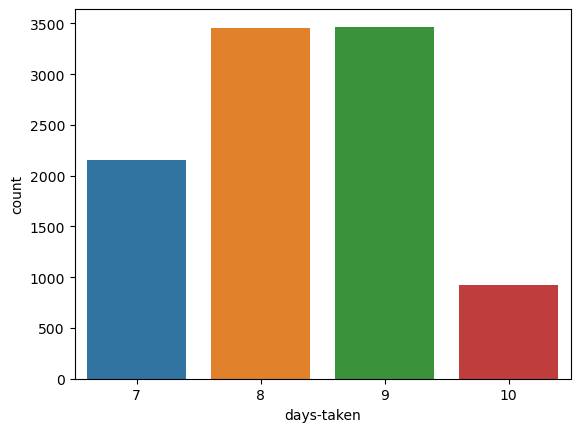

In [11]:
sns.countplot(x='days-taken', data=df)

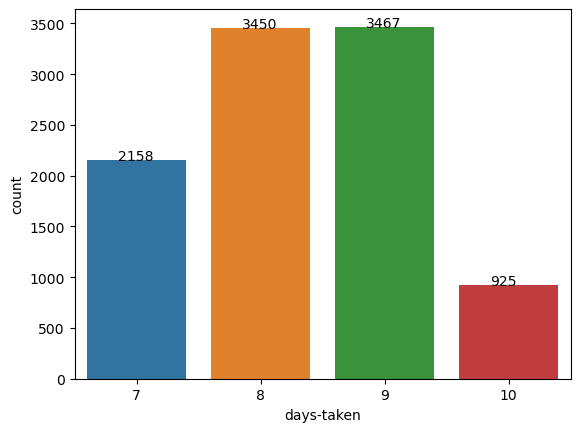

In [12]:
ax = sns.countplot(x='days-taken', data=df)

for p in ax.patches:
   ax.annotate('{:.0f}'.format(p.get_height()), (p.get_x()+0.25, p.get_height()+0.01))

plt.show()

In [13]:
# Encoding the output feature

def feature_encoding(df, col):
    temp_list = list(sorted(df[col].unique()))
    return dict(zip(temp_list, range(len(temp_list))))  

In [14]:
output_dict = feature_encoding(df, 'days-taken')
output_dict

{7: 0, 8: 1, 9: 2, 10: 3}

In [15]:
df['days-taken'] = df['days-taken'].map(output_dict)
df.head()

,purchase-date,quantity-purchased,postal-code,temp,description,prepcipitation,humidity,wind,weight,days-taken,latitude,longitude,distance,duration
0,2022-10-01T01:06:20-07:00,1,75453,17,Windy,0.10,0.89,33km/h,0.20,2,33.00025,-95.92817,2381.0,21.89
1,2022-10-01T01:06:40-07:00,1,71678,15,Windy,0.02,0.80,29km/h,0.91,1,34.02540,-91.81548,1992.0,18.67
2,2022-10-01T01:09:36-07:00,1,44092,13,Clear,0.07,0.58,31km/h,1.47,1,41.59797,-81.46867,755.0,7.15
3,2022-10-01T01:17:35-07:00,1,72394,19,Smoke,0.05,0.34,13km/h,0.55,2,35.05271,-90.61599,1799.0,16.63
4,2022-10-01T01:18:43-07:00,2,63087,9,Clear,0.06,0.90,38km/h,1.34,1,38.00888,-90.45835,1612.0,15.11


#### Objective:

* We must keep the distribution of output classes same in both train and test dataset.
* In order to get a similar distribution, we need to stratify the dataset based on the class values while splittig dataset.

In [16]:
from sklearn.model_selection import train_test_split

train_df, test_df = train_test_split(df, test_size = 0.2, random_state=42, stratify = df['days-taken'])

In [17]:
print(train_df.shape)
print(test_df.shape)

(8000, 14)
(2000, 14)


In [18]:
# Lets review the train_df for the output feature distribution (class distribution)

train_df['days-taken'].value_counts().sort_index()/train_df.shape[0]*100

0    21.575
1    34.500
2    34.675
3     9.250
Name: days-taken, dtype: float64

In [19]:
# Lets review the test_df for the output feature distribution (class distribution)

test_df['days-taken'].value_counts().sort_index()/test_df.shape[0]*100

0    21.60
1    34.50
2    34.65
3     9.25
Name: days-taken, dtype: float64

In [20]:
# Feature Extraction:

def split_date_feature(df, col):
    
    df['purchase_date'] = df[col].str.split('T').str[0]
    df['purchase_date'] = pd.to_datetime(df['purchase_date'])   # converting into datetime to add business days further    
    #df['purchase_time'] = df[col].str.split('T').str[1].str.split('-').str[0]
    
    df.drop(col, axis=1, inplace=True)
    df.reset_index(drop=True, inplace=True)

In [21]:
split_date_feature(train_df, 'purchase-date')
split_date_feature(test_df, 'purchase-date')



display(train_df.head())
display("-"*125)
display(train_df.head())

,quantity-purchased,postal-code,temp,description,prepcipitation,humidity,wind,weight,days-taken,latitude,longitude,distance,duration,purchase_date
0,1,71438,-9,Snow,0.86,0.93,14km/h,1.28,2,31.10092,-92.87511,2244.0,21.28,2022-12-05
1,1,97336,15,Sunny,0.07,0.18,37km/h,0.72,3,44.35669,-122.85092,4652.0,43.51,2022-11-05
2,1,75942,13,Rain,0.98,0.96,29km/h,0.57,2,30.82567,-94.41657,2403.0,22.91,2022-11-13
3,1,40601,18,Windy,0.05,0.86,16km/h,0.95,1,38.23294,-84.88327,1152.0,10.93,2022-10-28
4,1,24895,10,Haze,0.15,0.93,10km/h,0.45,1,37.37718,-81.58208,916.0,9.16,2022-10-19


'-----------------------------------------------------------------------------------------------------------------------------'

,quantity-purchased,postal-code,temp,description,prepcipitation,humidity,wind,weight,days-taken,latitude,longitude,distance,duration,purchase_date
0,1,71438,-9,Snow,0.86,0.93,14km/h,1.28,2,31.10092,-92.87511,2244.0,21.28,2022-12-05
1,1,97336,15,Sunny,0.07,0.18,37km/h,0.72,3,44.35669,-122.85092,4652.0,43.51,2022-11-05
2,1,75942,13,Rain,0.98,0.96,29km/h,0.57,2,30.82567,-94.41657,2403.0,22.91,2022-11-13
3,1,40601,18,Windy,0.05,0.86,16km/h,0.95,1,38.23294,-84.88327,1152.0,10.93,2022-10-28
4,1,24895,10,Haze,0.15,0.93,10km/h,0.45,1,37.37718,-81.58208,916.0,9.16,2022-10-19


#### Objective:

* Dispatched time = Handling time + Time taken by the courier partner to process and complete the custom formatlities
* Both the Handling time and the courier partner takes 1 business day each
* Overall, it takes two business days to generate the "Dispatched Date"

In [22]:
IND_holiday_list = ['2022-10-02', '2022-10-05','2022-10-24','2022-11-08','2022-12-25']

def handling_time(df, col):
    
    business_days = pd.tseries.offsets.CustomBusinessDay(n=2, weekmask='Mon Tue Wed Thu Fri Sat', holidays=IND_holiday_list)
    df['dispatched_date'] = df[col] + business_days
    df['dispatched_days'] = (df['dispatched_date'] - df[col]).dt.days

In [23]:
handling_time(train_df, 'purchase_date')
handling_time(test_df, 'purchase_date')



display(train_df.head())
display("-"*125)
display(train_df.head())

,quantity-purchased,postal-code,temp,description,prepcipitation,humidity,wind,weight,days-taken,latitude,longitude,distance,duration,purchase_date,dispatched_date,dispatched_days
0,1,71438,-9,Snow,0.86,0.93,14km/h,1.28,2,31.10092,-92.87511,2244.0,21.28,2022-12-05,2022-12-07,2
1,1,97336,15,Sunny,0.07,0.18,37km/h,0.72,3,44.35669,-122.85092,4652.0,43.51,2022-11-05,2022-11-09,4
2,1,75942,13,Rain,0.98,0.96,29km/h,0.57,2,30.82567,-94.41657,2403.0,22.91,2022-11-13,2022-11-15,2
3,1,40601,18,Windy,0.05,0.86,16km/h,0.95,1,38.23294,-84.88327,1152.0,10.93,2022-10-28,2022-10-31,3
4,1,24895,10,Haze,0.15,0.93,10km/h,0.45,1,37.37718,-81.58208,916.0,9.16,2022-10-19,2022-10-21,2


'-----------------------------------------------------------------------------------------------------------------------------'

,quantity-purchased,postal-code,temp,description,prepcipitation,humidity,wind,weight,days-taken,latitude,longitude,distance,duration,purchase_date,dispatched_date,dispatched_days
0,1,71438,-9,Snow,0.86,0.93,14km/h,1.28,2,31.10092,-92.87511,2244.0,21.28,2022-12-05,2022-12-07,2
1,1,97336,15,Sunny,0.07,0.18,37km/h,0.72,3,44.35669,-122.85092,4652.0,43.51,2022-11-05,2022-11-09,4
2,1,75942,13,Rain,0.98,0.96,29km/h,0.57,2,30.82567,-94.41657,2403.0,22.91,2022-11-13,2022-11-15,2
3,1,40601,18,Windy,0.05,0.86,16km/h,0.95,1,38.23294,-84.88327,1152.0,10.93,2022-10-28,2022-10-31,3
4,1,24895,10,Haze,0.15,0.93,10km/h,0.45,1,37.37718,-81.58208,916.0,9.16,2022-10-19,2022-10-21,2


In [24]:
# Just to check any of connection weekday comes out on weekend for train_df

train_df['dispatched_weekday'] = train_df['dispatched_date'].dt.day_name()
train_df['dispatched_weekday'].unique()

array(['Wednesday', 'Tuesday', 'Monday', 'Friday', 'Saturday', 'Thursday'],
      dtype=object)

In [25]:
# Just to check any of connection weekday comes out on weekend for test_df

test_df['dispatched_weekday'] = test_df['dispatched_date'].dt.day_name()
test_df['dispatched_weekday'].unique()

array(['Monday', 'Thursday', 'Saturday', 'Tuesday', 'Friday', 'Wednesday'],
      dtype=object)

### Objective: 
#### Connection_received_date:
* "Connection_received_date" is the date when USPS receives and scan the parcel at New Jersey, USPS center.
* Our **Primary task** is to derive this "Connection_received_date".
* The Buyers can trace their shipment from this date onwards through USPS tracking ID.
* We can share this date with the Buyer by stating that "You can trace your parcel using the given USPS tracking ID by {connection_received_date}".

* It usually takes 3 days to complete the process below such that:
    * Custom clearance at Delhi airport
    * Transit time between Delhi to New Jersey, USA
    * Custom clearance at the US airport
    * Transit time between US airport to USPS warehouse at New Jersey
    
***USPS : United State Postal Service

In [26]:
US_holiday_list = ['2022-10-10', '2022-11-24', '2022-12-25', '2023-01-01']

def connection_days(df, col):
    
    business_days = pd.tseries.offsets.CustomBusinessDay(n=3, weekmask='Mon Tue Wed Thu Fri Sat', holidays=US_holiday_list)
    df['connection_date'] = df[col] + business_days
    df['connection_days'] = (df['connection_date'] - df[col]).dt.days

In [27]:
connection_days(train_df, 'dispatched_date')
connection_days(test_df, 'dispatched_date')


display(train_df.head())
display("-"*125)
display(train_df.head())

,quantity-purchased,postal-code,temp,description,prepcipitation,humidity,wind,weight,days-taken,latitude,longitude,distance,duration,purchase_date,dispatched_date,dispatched_days,dispatched_weekday,connection_date,connection_days
0,1,71438,-9,Snow,0.86,0.93,14km/h,1.28,2,31.10092,-92.87511,2244.0,21.28,2022-12-05,2022-12-07,2,Wednesday,2022-12-10,3
1,1,97336,15,Sunny,0.07,0.18,37km/h,0.72,3,44.35669,-122.85092,4652.0,43.51,2022-11-05,2022-11-09,4,Wednesday,2022-11-12,3
2,1,75942,13,Rain,0.98,0.96,29km/h,0.57,2,30.82567,-94.41657,2403.0,22.91,2022-11-13,2022-11-15,2,Tuesday,2022-11-18,3
3,1,40601,18,Windy,0.05,0.86,16km/h,0.95,1,38.23294,-84.88327,1152.0,10.93,2022-10-28,2022-10-31,3,Monday,2022-11-03,3
4,1,24895,10,Haze,0.15,0.93,10km/h,0.45,1,37.37718,-81.58208,916.0,9.16,2022-10-19,2022-10-21,2,Friday,2022-10-25,4


'-----------------------------------------------------------------------------------------------------------------------------'

,quantity-purchased,postal-code,temp,description,prepcipitation,humidity,wind,weight,days-taken,latitude,longitude,distance,duration,purchase_date,dispatched_date,dispatched_days,dispatched_weekday,connection_date,connection_days
0,1,71438,-9,Snow,0.86,0.93,14km/h,1.28,2,31.10092,-92.87511,2244.0,21.28,2022-12-05,2022-12-07,2,Wednesday,2022-12-10,3
1,1,97336,15,Sunny,0.07,0.18,37km/h,0.72,3,44.35669,-122.85092,4652.0,43.51,2022-11-05,2022-11-09,4,Wednesday,2022-11-12,3
2,1,75942,13,Rain,0.98,0.96,29km/h,0.57,2,30.82567,-94.41657,2403.0,22.91,2022-11-13,2022-11-15,2,Tuesday,2022-11-18,3
3,1,40601,18,Windy,0.05,0.86,16km/h,0.95,1,38.23294,-84.88327,1152.0,10.93,2022-10-28,2022-10-31,3,Monday,2022-11-03,3
4,1,24895,10,Haze,0.15,0.93,10km/h,0.45,1,37.37718,-81.58208,916.0,9.16,2022-10-19,2022-10-21,2,Friday,2022-10-25,4


In [28]:
# Just to check any of the Connection weekday comes out on weekend for train_df

train_df['connection_weekday'] = train_df['connection_date'].dt.day_name()
train_df['connection_weekday'].unique()

array(['Saturday', 'Friday', 'Thursday', 'Tuesday', 'Wednesday', 'Monday'],
      dtype=object)

In [29]:
# Just to check any of the Connection weekday comes out on weekend for train_df

test_df['connection_weekday'] = test_df['connection_date'].dt.day_name()
test_df['connection_weekday'].unique()

array(['Thursday', 'Monday', 'Wednesday', 'Saturday', 'Tuesday', 'Friday'],
      dtype=object)

### Objective:

* Bucktize the weights into 500 grams, 1000 grams, 1500 grams, 2000 grams and 2500 grams & more

In [30]:
def weight_transformation(df, col):
    df['weight_transformed'] =  np.where(df[col]>2.5,6, 
                                np.where(df[col]>2.0,5, 
                                np.where(df[col]>1.5,4, 
                                np.where(df[col]>1.0,3,
                                np.where(df[col]>0.5,2,1)))))
    df.drop(col, axis=1, inplace=True)

In [31]:
weight_transformation(train_df, 'weight')
weight_transformation(test_df, 'weight')


display(train_df.head())
display("-"*125)
display(train_df.head())

,quantity-purchased,postal-code,temp,description,prepcipitation,humidity,wind,days-taken,latitude,longitude,distance,duration,purchase_date,dispatched_date,dispatched_days,dispatched_weekday,connection_date,connection_days,connection_weekday,weight_transformed
0,1,71438,-9,Snow,0.86,0.93,14km/h,2,31.10092,-92.87511,2244.0,21.28,2022-12-05,2022-12-07,2,Wednesday,2022-12-10,3,Saturday,3
1,1,97336,15,Sunny,0.07,0.18,37km/h,3,44.35669,-122.85092,4652.0,43.51,2022-11-05,2022-11-09,4,Wednesday,2022-11-12,3,Saturday,2
2,1,75942,13,Rain,0.98,0.96,29km/h,2,30.82567,-94.41657,2403.0,22.91,2022-11-13,2022-11-15,2,Tuesday,2022-11-18,3,Friday,2
3,1,40601,18,Windy,0.05,0.86,16km/h,1,38.23294,-84.88327,1152.0,10.93,2022-10-28,2022-10-31,3,Monday,2022-11-03,3,Thursday,2
4,1,24895,10,Haze,0.15,0.93,10km/h,1,37.37718,-81.58208,916.0,9.16,2022-10-19,2022-10-21,2,Friday,2022-10-25,4,Tuesday,1


'-----------------------------------------------------------------------------------------------------------------------------'

,quantity-purchased,postal-code,temp,description,prepcipitation,humidity,wind,days-taken,latitude,longitude,distance,duration,purchase_date,dispatched_date,dispatched_days,dispatched_weekday,connection_date,connection_days,connection_weekday,weight_transformed
0,1,71438,-9,Snow,0.86,0.93,14km/h,2,31.10092,-92.87511,2244.0,21.28,2022-12-05,2022-12-07,2,Wednesday,2022-12-10,3,Saturday,3
1,1,97336,15,Sunny,0.07,0.18,37km/h,3,44.35669,-122.85092,4652.0,43.51,2022-11-05,2022-11-09,4,Wednesday,2022-11-12,3,Saturday,2
2,1,75942,13,Rain,0.98,0.96,29km/h,2,30.82567,-94.41657,2403.0,22.91,2022-11-13,2022-11-15,2,Tuesday,2022-11-18,3,Friday,2
3,1,40601,18,Windy,0.05,0.86,16km/h,1,38.23294,-84.88327,1152.0,10.93,2022-10-28,2022-10-31,3,Monday,2022-11-03,3,Thursday,2
4,1,24895,10,Haze,0.15,0.93,10km/h,1,37.37718,-81.58208,916.0,9.16,2022-10-19,2022-10-21,2,Friday,2022-10-25,4,Tuesday,1


In [32]:
# Encoding the Description feature

description_dict = feature_encoding(df, 'description')

In [33]:
train_df['description'] = train_df['description'].map(description_dict)
test_df['description'] = test_df['description'].map(description_dict)

display(train_df.head())
display("-"*125)
display(train_df.head())

,quantity-purchased,postal-code,temp,description,prepcipitation,humidity,wind,days-taken,latitude,longitude,distance,duration,purchase_date,dispatched_date,dispatched_days,dispatched_weekday,connection_date,connection_days,connection_weekday,weight_transformed
0,1,71438,-9,8,0.86,0.93,14km/h,2,31.10092,-92.87511,2244.0,21.28,2022-12-05,2022-12-07,2,Wednesday,2022-12-10,3,Saturday,3
1,1,97336,15,9,0.07,0.18,37km/h,3,44.35669,-122.85092,4652.0,43.51,2022-11-05,2022-11-09,4,Wednesday,2022-11-12,3,Saturday,2
2,1,75942,13,5,0.98,0.96,29km/h,2,30.82567,-94.41657,2403.0,22.91,2022-11-13,2022-11-15,2,Tuesday,2022-11-18,3,Friday,2
3,1,40601,18,10,0.05,0.86,16km/h,1,38.23294,-84.88327,1152.0,10.93,2022-10-28,2022-10-31,3,Monday,2022-11-03,3,Thursday,2
4,1,24895,10,4,0.15,0.93,10km/h,1,37.37718,-81.58208,916.0,9.16,2022-10-19,2022-10-21,2,Friday,2022-10-25,4,Tuesday,1


'-----------------------------------------------------------------------------------------------------------------------------'

,quantity-purchased,postal-code,temp,description,prepcipitation,humidity,wind,days-taken,latitude,longitude,distance,duration,purchase_date,dispatched_date,dispatched_days,dispatched_weekday,connection_date,connection_days,connection_weekday,weight_transformed
0,1,71438,-9,8,0.86,0.93,14km/h,2,31.10092,-92.87511,2244.0,21.28,2022-12-05,2022-12-07,2,Wednesday,2022-12-10,3,Saturday,3
1,1,97336,15,9,0.07,0.18,37km/h,3,44.35669,-122.85092,4652.0,43.51,2022-11-05,2022-11-09,4,Wednesday,2022-11-12,3,Saturday,2
2,1,75942,13,5,0.98,0.96,29km/h,2,30.82567,-94.41657,2403.0,22.91,2022-11-13,2022-11-15,2,Tuesday,2022-11-18,3,Friday,2
3,1,40601,18,10,0.05,0.86,16km/h,1,38.23294,-84.88327,1152.0,10.93,2022-10-28,2022-10-31,3,Monday,2022-11-03,3,Thursday,2
4,1,24895,10,4,0.15,0.93,10km/h,1,37.37718,-81.58208,916.0,9.16,2022-10-19,2022-10-21,2,Friday,2022-10-25,4,Tuesday,1


In [34]:
# Splitting the Wind feature to "Km/h"

def split_feature(df, col):
    df['wind'] = df[col].str.split('k').str[0]
    df['wind'] = df['wind'].astype("int")


In [35]:
split_feature(train_df, 'wind')
split_feature(test_df, 'wind')


display(train_df.head())
display("-"*125)
display(train_df.head())

,quantity-purchased,postal-code,temp,description,prepcipitation,humidity,wind,days-taken,latitude,longitude,distance,duration,purchase_date,dispatched_date,dispatched_days,dispatched_weekday,connection_date,connection_days,connection_weekday,weight_transformed
0,1,71438,-9,8,0.86,0.93,14,2,31.10092,-92.87511,2244.0,21.28,2022-12-05,2022-12-07,2,Wednesday,2022-12-10,3,Saturday,3
1,1,97336,15,9,0.07,0.18,37,3,44.35669,-122.85092,4652.0,43.51,2022-11-05,2022-11-09,4,Wednesday,2022-11-12,3,Saturday,2
2,1,75942,13,5,0.98,0.96,29,2,30.82567,-94.41657,2403.0,22.91,2022-11-13,2022-11-15,2,Tuesday,2022-11-18,3,Friday,2
3,1,40601,18,10,0.05,0.86,16,1,38.23294,-84.88327,1152.0,10.93,2022-10-28,2022-10-31,3,Monday,2022-11-03,3,Thursday,2
4,1,24895,10,4,0.15,0.93,10,1,37.37718,-81.58208,916.0,9.16,2022-10-19,2022-10-21,2,Friday,2022-10-25,4,Tuesday,1


'-----------------------------------------------------------------------------------------------------------------------------'

,quantity-purchased,postal-code,temp,description,prepcipitation,humidity,wind,days-taken,latitude,longitude,distance,duration,purchase_date,dispatched_date,dispatched_days,dispatched_weekday,connection_date,connection_days,connection_weekday,weight_transformed
0,1,71438,-9,8,0.86,0.93,14,2,31.10092,-92.87511,2244.0,21.28,2022-12-05,2022-12-07,2,Wednesday,2022-12-10,3,Saturday,3
1,1,97336,15,9,0.07,0.18,37,3,44.35669,-122.85092,4652.0,43.51,2022-11-05,2022-11-09,4,Wednesday,2022-11-12,3,Saturday,2
2,1,75942,13,5,0.98,0.96,29,2,30.82567,-94.41657,2403.0,22.91,2022-11-13,2022-11-15,2,Tuesday,2022-11-18,3,Friday,2
3,1,40601,18,10,0.05,0.86,16,1,38.23294,-84.88327,1152.0,10.93,2022-10-28,2022-10-31,3,Monday,2022-11-03,3,Thursday,2
4,1,24895,10,4,0.15,0.93,10,1,37.37718,-81.58208,916.0,9.16,2022-10-19,2022-10-21,2,Friday,2022-10-25,4,Tuesday,1


### Objective:

* **Google Maps API's geocode** function is used to find the latitude and longitude coordinates of the buyer's postal address.
* By using latitude and longitude coordinates, we can find out the **travel distance and travel time**.

In [36]:
def get_lat_long(df, col):
    
    temp_df = df[df['latitude'].isna()]    
    if temp_df.empty:
        return df
    
    else:        
        gmaps = googlemaps.Client(key=api_key)
        lat_list = []
        long_list = []

        for postal_code in temp_df['postal-code']:
            # Geocode the postal code using the Google Maps API
            geocode_result = gmaps.geocode(postal_code)

            if geocode_result:
                # Extract the latitude and longitude from the geocode result
                lat = geocode_result[0]['geometry']['location']['lat']
                long = geocode_result[0]['geometry']['location']['lng']

                lat_list.append(lat)
                long_list.append(long)

            else:
                print(f'Could not find coordinates for this postal code {postal_code}')
                lat_list.append(0)
                long_list.append(0)        

        temp_df['latitude'] = lat_list
        temp_df['longitude'] = long_list
        
        df = df.fillna(temp_df)
        df.drop(df[df['latitude']==0].index, axis=0, inplace=True)
        df.reset_index(drop=True, inplace=True)
        return df

In [37]:
get_lat_long(train_df, 'postal-code')
get_lat_long(test_df, 'postal-code')


display(train_df.head())
display("-"*125)
display(train_df.head())

,quantity-purchased,postal-code,temp,description,prepcipitation,humidity,wind,days-taken,latitude,longitude,distance,duration,purchase_date,dispatched_date,dispatched_days,dispatched_weekday,connection_date,connection_days,connection_weekday,weight_transformed
0,1,71438,-9,8,0.86,0.93,14,2,31.10092,-92.87511,2244.0,21.28,2022-12-05,2022-12-07,2,Wednesday,2022-12-10,3,Saturday,3
1,1,97336,15,9,0.07,0.18,37,3,44.35669,-122.85092,4652.0,43.51,2022-11-05,2022-11-09,4,Wednesday,2022-11-12,3,Saturday,2
2,1,75942,13,5,0.98,0.96,29,2,30.82567,-94.41657,2403.0,22.91,2022-11-13,2022-11-15,2,Tuesday,2022-11-18,3,Friday,2
3,1,40601,18,10,0.05,0.86,16,1,38.23294,-84.88327,1152.0,10.93,2022-10-28,2022-10-31,3,Monday,2022-11-03,3,Thursday,2
4,1,24895,10,4,0.15,0.93,10,1,37.37718,-81.58208,916.0,9.16,2022-10-19,2022-10-21,2,Friday,2022-10-25,4,Tuesday,1


'-----------------------------------------------------------------------------------------------------------------------------'

,quantity-purchased,postal-code,temp,description,prepcipitation,humidity,wind,days-taken,latitude,longitude,distance,duration,purchase_date,dispatched_date,dispatched_days,dispatched_weekday,connection_date,connection_days,connection_weekday,weight_transformed
0,1,71438,-9,8,0.86,0.93,14,2,31.10092,-92.87511,2244.0,21.28,2022-12-05,2022-12-07,2,Wednesday,2022-12-10,3,Saturday,3
1,1,97336,15,9,0.07,0.18,37,3,44.35669,-122.85092,4652.0,43.51,2022-11-05,2022-11-09,4,Wednesday,2022-11-12,3,Saturday,2
2,1,75942,13,5,0.98,0.96,29,2,30.82567,-94.41657,2403.0,22.91,2022-11-13,2022-11-15,2,Tuesday,2022-11-18,3,Friday,2
3,1,40601,18,10,0.05,0.86,16,1,38.23294,-84.88327,1152.0,10.93,2022-10-28,2022-10-31,3,Monday,2022-11-03,3,Thursday,2
4,1,24895,10,4,0.15,0.93,10,1,37.37718,-81.58208,916.0,9.16,2022-10-19,2022-10-21,2,Friday,2022-10-25,4,Tuesday,1


### Objective:

* Our partner USPS center is at New Jersey where the items are received, scanned and then sent out for the delivery in variours parts of the USA.
* The USPS center of New Jersey has Latitude as 40.5784°N and Longitude as 74.2833°W.
* We need to find out the distance between this USPS center and the buyers's postal code.
* We are using the **distance_matrix** function of **Google Map API** to find the **travel distance and travel time**.
* Distance are in KM and durations are in Hours. 

In [38]:
def distance_matrix(df, lat_col, long_col):
    
    origin_lat = str(40.5784)
    origin_long = str(-74.2833)
    
    temp_df = df[df['distance'].isna()]    
    if temp_df.empty:
        return df
    
    else:       
        gmaps = googlemaps.Client(key=api_key)
        distance_list = []
        duration_list = []

        for i,j in zip(temp_df[lat_col], temp_df[long_col]):

            temp_result = gmaps.distance_matrix([origin_lat+" "+origin_long],[str(i)+" "+str(j)], 
                                                mode='driving')['rows'][0]['elements'][0]

            if temp_result['status']=='OK':          
                distance_list.append(temp_result['distance']['text'])
                duration_list.append((temp_result['duration']['value'])/3600)   # Converted into hours

            else:
                print(f'Could not find Distance for this latitude {i} & longitude {j}.')
                distance_list.append(0)
                duration_list.append(0)    
        
        temp_df['distance'] = distance_list
        temp_df['duration'] = duration_list
                
        df = df.combine_first(temp_df) # combine_first works similar as fillna()
        df['distance'] = df['distance'].apply(lambda x: x.split(" ")[0].replace(",","") if isinstance(x, str) else x)
        df.drop(df[df['duration']==0].index, axis=0, inplace=True)
        df.reset_index(drop=True, inplace=True)

        return df

In [39]:
distance_matrix(train_df, 'latitude', 'longitude')
distance_matrix(test_df, 'latitude', 'longitude')


display(train_df.head())
display("-"*125)
display(train_df.head())

,quantity-purchased,postal-code,temp,description,prepcipitation,humidity,wind,days-taken,latitude,longitude,distance,duration,purchase_date,dispatched_date,dispatched_days,dispatched_weekday,connection_date,connection_days,connection_weekday,weight_transformed
0,1,71438,-9,8,0.86,0.93,14,2,31.10092,-92.87511,2244.0,21.28,2022-12-05,2022-12-07,2,Wednesday,2022-12-10,3,Saturday,3
1,1,97336,15,9,0.07,0.18,37,3,44.35669,-122.85092,4652.0,43.51,2022-11-05,2022-11-09,4,Wednesday,2022-11-12,3,Saturday,2
2,1,75942,13,5,0.98,0.96,29,2,30.82567,-94.41657,2403.0,22.91,2022-11-13,2022-11-15,2,Tuesday,2022-11-18,3,Friday,2
3,1,40601,18,10,0.05,0.86,16,1,38.23294,-84.88327,1152.0,10.93,2022-10-28,2022-10-31,3,Monday,2022-11-03,3,Thursday,2
4,1,24895,10,4,0.15,0.93,10,1,37.37718,-81.58208,916.0,9.16,2022-10-19,2022-10-21,2,Friday,2022-10-25,4,Tuesday,1


'-----------------------------------------------------------------------------------------------------------------------------'

,quantity-purchased,postal-code,temp,description,prepcipitation,humidity,wind,days-taken,latitude,longitude,distance,duration,purchase_date,dispatched_date,dispatched_days,dispatched_weekday,connection_date,connection_days,connection_weekday,weight_transformed
0,1,71438,-9,8,0.86,0.93,14,2,31.10092,-92.87511,2244.0,21.28,2022-12-05,2022-12-07,2,Wednesday,2022-12-10,3,Saturday,3
1,1,97336,15,9,0.07,0.18,37,3,44.35669,-122.85092,4652.0,43.51,2022-11-05,2022-11-09,4,Wednesday,2022-11-12,3,Saturday,2
2,1,75942,13,5,0.98,0.96,29,2,30.82567,-94.41657,2403.0,22.91,2022-11-13,2022-11-15,2,Tuesday,2022-11-18,3,Friday,2
3,1,40601,18,10,0.05,0.86,16,1,38.23294,-84.88327,1152.0,10.93,2022-10-28,2022-10-31,3,Monday,2022-11-03,3,Thursday,2
4,1,24895,10,4,0.15,0.93,10,1,37.37718,-81.58208,916.0,9.16,2022-10-19,2022-10-21,2,Friday,2022-10-25,4,Tuesday,1


In [40]:
train_df.head()

,quantity-purchased,postal-code,temp,description,prepcipitation,humidity,wind,days-taken,latitude,longitude,distance,duration,purchase_date,dispatched_date,dispatched_days,dispatched_weekday,connection_date,connection_days,connection_weekday,weight_transformed
0,1,71438,-9,8,0.86,0.93,14,2,31.10092,-92.87511,2244.0,21.28,2022-12-05,2022-12-07,2,Wednesday,2022-12-10,3,Saturday,3
1,1,97336,15,9,0.07,0.18,37,3,44.35669,-122.85092,4652.0,43.51,2022-11-05,2022-11-09,4,Wednesday,2022-11-12,3,Saturday,2
2,1,75942,13,5,0.98,0.96,29,2,30.82567,-94.41657,2403.0,22.91,2022-11-13,2022-11-15,2,Tuesday,2022-11-18,3,Friday,2
3,1,40601,18,10,0.05,0.86,16,1,38.23294,-84.88327,1152.0,10.93,2022-10-28,2022-10-31,3,Monday,2022-11-03,3,Thursday,2
4,1,24895,10,4,0.15,0.93,10,1,37.37718,-81.58208,916.0,9.16,2022-10-19,2022-10-21,2,Friday,2022-10-25,4,Tuesday,1


In [41]:
train_df.columns

Index(['quantity-purchased', 'postal-code', 'temp', 'description',
       'prepcipitation', 'humidity', 'wind', 'days-taken', 'latitude',
       'longitude', 'distance', 'duration', 'purchase_date', 'dispatched_date',
       'dispatched_days', 'dispatched_weekday', 'connection_date',
       'connection_days', 'connection_weekday', 'weight_transformed'],
      dtype='object')

In [42]:
# Lets remove the features whic are not required for the model

cols = ['postal-code','latitude', 'longitude', 'purchase_date', 'dispatched_date', 
        'dispatched_weekday','connection_date', 'connection_weekday']

train_df.drop(cols, axis=1, inplace =True)
test_df.drop(cols, axis=1, inplace =True)

In [43]:
reset_cols = ['quantity-purchased', 'weight_transformed','dispatched_days','connection_days','description',
              'temp', 'prepcipitation', 'humidity', 'wind', 'distance' , 'duration', 'days-taken']

train_df=train_df.reindex(reset_cols, axis=1)
test_df=test_df.reindex(reset_cols, axis=1)

In [44]:
display(train_df.head())
display("-"*125)
display(train_df.head())

,quantity-purchased,weight_transformed,dispatched_days,connection_days,description,temp,prepcipitation,humidity,wind,distance,duration,days-taken
0,1,3,2,3,8,-9,0.86,0.93,14,2244.0,21.28,2
1,1,2,4,3,9,15,0.07,0.18,37,4652.0,43.51,3
2,1,2,2,3,5,13,0.98,0.96,29,2403.0,22.91,2
3,1,2,3,3,10,18,0.05,0.86,16,1152.0,10.93,1
4,1,1,2,4,4,10,0.15,0.93,10,916.0,9.16,1


'-----------------------------------------------------------------------------------------------------------------------------'

,quantity-purchased,weight_transformed,dispatched_days,connection_days,description,temp,prepcipitation,humidity,wind,distance,duration,days-taken
0,1,3,2,3,8,-9,0.86,0.93,14,2244.0,21.28,2
1,1,2,4,3,9,15,0.07,0.18,37,4652.0,43.51,3
2,1,2,2,3,5,13,0.98,0.96,29,2403.0,22.91,2
3,1,2,3,3,10,18,0.05,0.86,16,1152.0,10.93,1
4,1,1,2,4,4,10,0.15,0.93,10,916.0,9.16,1


In [45]:
train_df.to_excel(r'C:\Users\Ricky\Downloads\train1.xlsx', index=False, header=True)
test_df.to_excel(r'C:\Users\Ricky\Downloads\test1.xlsx', index=False, header=True)

#### Categorical features below do not require feature scaling:
* quantity-purchased
* weight_transformed
* dispatched_days
* connection_days
* description


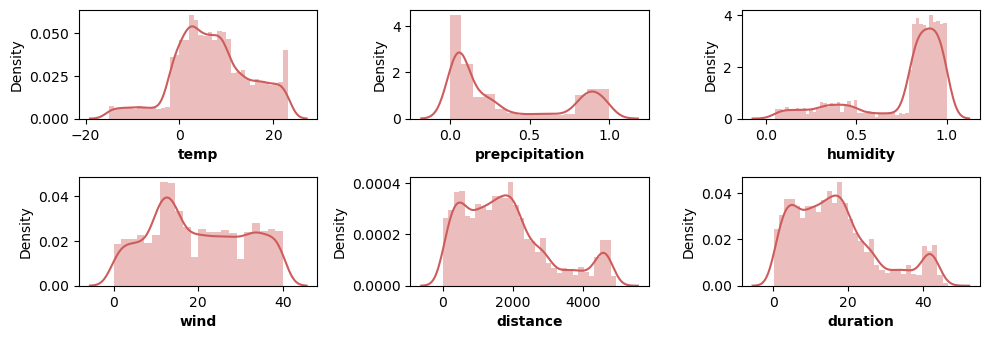

In [46]:
numeric_features = train_df.iloc[:,5:-1]

plt.figure(figsize=(10, 100))

for idx, col in enumerate(numeric_features):
    plt.subplot(60, 3, idx+1)
    sns.distplot(x=train_df[col], color='indianred')
    plt.xlabel(col, weight='bold')
    plt.tight_layout()

In [47]:
# Robust Scaler

from sklearn.preprocessing import RobustScaler
robustscaler = RobustScaler()

In [48]:
train_df.iloc[:,5:-1] = robustscaler.fit_transform(train_df.iloc[:,5:-1])
train_df.head()

,quantity-purchased,weight_transformed,dispatched_days,connection_days,description,temp,prepcipitation,humidity,wind,distance,duration,days-taken
0,1,3,2,3,8,-1.5,0.945946,0.411765,-0.210526,0.405811,0.434478,2
1,1,2,4,3,9,0.9,-0.121622,-4.000000,1.000000,1.943487,1.992292,3
2,1,2,2,3,5,0.7,1.108108,0.588235,0.578947,0.507344,0.548704,2
3,1,2,3,3,10,1.2,-0.148649,0.000000,-0.105263,-0.291507,-0.290820,1
4,1,1,2,4,4,0.4,-0.013514,0.411765,-0.421053,-0.442209,-0.414856,1


In [49]:
robustscaler.scale_

array([1.000e+01, 7.400e-01, 1.700e-01, 1.900e+01, 1.566e+03, 1.427e+01])

In [50]:
robustscaler.center_

array([6.0000e+00, 1.6000e-01, 8.6000e-01, 1.8000e+01, 1.6085e+03,
       1.5080e+01])

In [51]:
test_df.iloc[:,5:-1] = robustscaler.transform(test_df.iloc[:,5:-1])
test_df.head()

,quantity-purchased,weight_transformed,dispatched_days,connection_days,description,temp,prepcipitation,humidity,wind,distance,duration,days-taken
0,1,1,3,3,5,-0.6,0.945946,-0.058824,0.263158,0.393040,0.410652,2
1,1,2,2,4,9,0.3,-0.094595,-2.941176,1.052632,0.374521,0.361598,1
2,1,2,2,4,3,-0.2,0.054054,0.117647,-0.894737,1.913474,1.902593,2
3,1,1,2,4,1,-0.4,0.878378,0.705882,0.052632,-0.740421,-0.716188,0
4,1,2,2,5,9,0.3,-0.175676,-2.235294,0.052632,-0.764687,-0.761037,0


In [52]:
train_df.dtypes

quantity-purchased      int64
weight_transformed      int32
dispatched_days         int64
connection_days         int64
description             int64
temp                  float64
prepcipitation        float64
humidity              float64
wind                  float64
distance              float64
duration              float64
days-taken              int64
dtype: object

In [53]:
X_train = train_df.iloc[:,:-1]
y_train = train_df.iloc[:,-1]

X_test = test_df.iloc[:,:-1]
y_test = test_df.iloc[:,-1]

In [54]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(8000, 11)
(2000, 11)
(8000,)
(2000,)


In [55]:
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report,ConfusionMatrixDisplay, log_loss,\
                            precision_score, recall_score, f1_score, roc_auc_score, roc_curve, confusion_matrix

from sklearn.model_selection import cross_val_score


In [56]:
models = []

models.append(('LogisticReg',LogisticRegression()))
models.append(('KNeighborsClf',KNeighborsClassifier()))
models.append(('DecisionTreeClf',DecisionTreeClassifier()))
models.append(('RandomForestClf',RandomForestClassifier()))

In [57]:
metrics = pd.DataFrame(index=['Train_Accuracy', 'Test_Accuracy','CV_Accuracy', 
                              'precision', 'recall', 'f1_Score', 'roc_auc', 'log_loss'],
                       columns=['LogisticReg','KNeighborsClf', 'DecisionTreeClf', 'RandomForestClf'])
metrics

,LogisticReg,KNeighborsClf,DecisionTreeClf,RandomForestClf
Train_Accuracy,NaN,NaN,NaN,NaN
Test_Accuracy,NaN,NaN,NaN,NaN
CV_Accuracy,NaN,NaN,NaN,NaN
precision,NaN,NaN,NaN,NaN
recall,NaN,NaN,NaN,NaN
f1_Score,NaN,NaN,NaN,NaN
roc_auc,NaN,NaN,NaN,NaN
log_loss,NaN,NaN,NaN,NaN


In [58]:
"""
Accuracy = accuracy_score(true, predicted) # Calculate Accuracy
f1_Score = f1_score(true, predicted) # Calculate F1-score
precision = precision_score(true, predicted) # Calculate Precision
recall = recall_score(true, predicted)  # Calculate Recall
roc_auc = roc_auc_score(true, predicted) #Calculate Roc

"""

'\nAccuracy = accuracy_score(true, predicted) # Calculate Accuracy\nf1_Score = f1_score(true, predicted) # Calculate F1-score\nprecision = precision_score(true, predicted) # Calculate Precision\nrecall = recall_score(true, predicted)  # Calculate Recall\nroc_auc = roc_auc_score(true, predicted) #Calculate Roc\n\n'

In [59]:
for name, model in models:
    model.fit(X_train, y_train)
    
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    
    train_accuracy = accuracy_score(y_train, y_train_pred)
    metrics.loc['Train_Accuracy', name] = round(train_accuracy*100,2)

    test_accuracy = accuracy_score(y_test, y_test_pred)
    metrics.loc['Test_Accuracy', name] = round(test_accuracy*100,2)

    cv_result = cross_val_score(model, X_train, y_train, cv = 3, scoring ='accuracy')
    print(f"{name:{13}} {cv_result} {cv_result.mean():{18}} {cv_result.std():{18}}")
    metrics.loc['CV_Accuracy', name] = round(cv_result.mean()*100,2)
    
    precision = precision_score(y_test, y_test_pred, average="weighted")
    metrics.loc['precision', name] = round(precision*100,2)

    recall = recall_score(y_test, y_test_pred, average="weighted")
    metrics.loc['recall', name] = round(recall*100,2)
    
    f1_Score = f1_score(y_test, y_test_pred, average="weighted")
    metrics.loc['f1_Score', name] = round(f1_Score*100,2)
    
  
    # Probablities based scores
    y_preb_probs = model.predict_proba(X_test)

    roc_auc = roc_auc_score(y_test, y_preb_probs, average="weighted", multi_class = "ovr")
    metrics.loc['roc_auc', name] = round(roc_auc*100,2)
    
    logloss = log_loss(y_test, y_preb_probs)
    metrics.loc['log_loss', name] = logloss
    
    
metrics

LogisticReg   [0.76677915 0.76677915 0.75093773]  0.761498679881819 0.007467716142170856
KNeighborsClf [0.66929134 0.65729284 0.65941485]  0.661999676897102 0.005228255595343559
DecisionTreeClf [0.72590926 0.72365954 0.71380345] 0.7211240849207426 0.0052573168639351775
RandomForestClf [0.77315336 0.77802775 0.76819205] 0.7731243834580693 0.004015459366937177


,LogisticReg,KNeighborsClf,DecisionTreeClf,RandomForestClf
Train_Accuracy,76.5,79.96,100.0,100.0
Test_Accuracy,76.5,68.6,71.5,77.4
CV_Accuracy,76.15,66.2,72.11,77.31
precision,76.4,68.39,71.66,77.55
recall,76.5,68.6,71.5,77.4
f1_Score,76.44,68.47,71.54,77.29
roc_auc,91.93,85.93,78.84,92.51
log_loss,0.483568,1.569489,10.272441,0.453392


In [60]:
from sklearn.model_selection import GridSearchCV

In [61]:
# Random Forest
"""
param_grid = {'criterion' : ['gini', 'entropy'],
        'n_estimators' : [10,100,200,300],
        'max_depth' : [5,10,15,20],
        'max_features':  [5,6,7,8,9,10],
        'min_samples_leaf': [5,6,7,8,9,10],
        'oob_score' : [True,False],
        'n_jobs': [-1],
        'random_state': [42]
        }

rf_model = GridSearchCV(RandomForestClassifier(), param_grid, scoring='accuracy')
rf_model.fit(X_train,y_train)
rf_model.best_params_

best_params = rf_model.best_params_
best_params

"""

"\nparam_grid = {'criterion' : ['gini', 'entropy'],\n        'n_estimators' : [10,100,200,300],\n        'max_depth' : [5,10,15,20],\n        'max_features':  [5,6,7,8,9,10],\n        'min_samples_leaf': [5,6,7,8,9,10],\n        'oob_score' : [True,False],\n        'n_jobs': [-1],\n        'random_state': [42]\n        }\n\nrf_model = GridSearchCV(RandomForestClassifier(), param_grid, scoring='accuracy')\nrf_model.fit(X_train,y_train)\nrf_model.best_params_\n\nbest_params = rf_model.best_params_\nbest_params\n\n"

In [62]:
best_params = {"criterion": 'entropy', "n_estimators": 10, "max_depth": 5, "max_features": 7, 
                                  "min_samples_leaf": 7, "oob_score":True, "random_state":42}

In [63]:
rf_model = RandomForestClassifier(**best_params)
rf_model.fit(X_train,y_train)
y_pred_rf = rf_model.predict(X_test)
accuracy_score(y_test, y_pred_rf)

0.781

In [64]:
f1_Score = f1_score(y_test, y_test_pred, average="weighted")
f1_Score

0.7728979413771132

In [65]:
cm = confusion_matrix(y_test, y_test_pred)

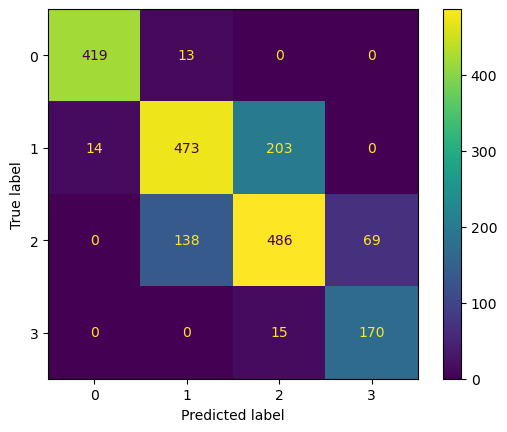

In [66]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()